# Convolutional Neural Network Data Analysis
In this chapter, we have introduced the concepts of Convolutional Neural Networks (CNN), which are a powerful class of deep learning models particularly suited for image data. And in this project, we apply CNN techniques to a novel task in the domain of urban economics: **analyzing the housing price index of 70 large and medium-sized cities in China**. 

Rather than using traditional econometric approaches, we adopt a **time series imaging** framework. Specifically, we convert each city’s monthly housing price index time series into an image representation using methods such as Gramian Angular Fields (GAF), Markov Transition Fields (MTF), and Recurrence Plots (RP).

These image representations are then used as inputs to a ResNet-18 convolutional neural network. The goal of our model is to predict whether housing prices will increase in the future, framing this as a binary classification problem. This approach demonstrates how modern deep learning techniques can be adapted to structured economic time series data through the lens of image-based learning

**Learning Goal**: after finishing this project, you would know:
* structure of ResNet18
* build ResNet18 in PyTorch

## Contents
* [0 - Import Packages](#0---import-packages)
* [1 - Data](#1---data)
  * [1.1 - descriptive analysis](#11---descriptive-analysis)
  * [1.2 - imagine time series](#12---imagine-time-series-在后面添加几个chunk画图)
  * [1.3 - transform to DataLoader](#13---transform-to-dataloader)
* [2 - ResNet](#2---resnet)
  * [2.1 - structure](#21---structure)
  * [2.2 - basic block](#22---basic-block)
  * [2.3 - build ResNet18](#23---build-resnet18)
* [3 - Train and Test Utility](#3---train-and-test-utility)
* [4 - Results](#4---results)
  * [4.1 - ARIMA](#41---arima)
  * [4.2 - ROC comparison](#42---roc-comparison)

## 0 - Import Packages

Most packages we have used in previous chapters. In addition, we use 3 algorithms in `pyts` to transform time series into images.

In [ ]:
import pandas as pd 
import numpy as np
# used for time series imaging 
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_curve, auc
# imports the ARIMA model for time series forecasting
from statsmodels.tsa.arima.model import ARIMA
# imports the normal distribution object
from scipy.stats import norm

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) # set random seed if using CUDA
torch.backends.cudnn.deterministic = True # set deterministic mode for cuDNN if using CUDA
torch.mps.manual_seed(42) # set random seed if using MPS (macOS)

## 1 - Data

Our data includes
* $X$: housing price indices for 70 large and medium-sized cities in China from January 2011 to October 2024 ($N = 70, T = 166$)
* $y$: if housing price increased between November 2024 and April 2025, then $y = 1$; otherwise, $y = 0$.
  

In [2]:
df = pd.read_csv('data.csv') # read data
df.head(5) # display first 5 rows

,city,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,y
0,北京,100,100.5,100.5000,100.600500,100.801701,100.902503,100.902503,100.902503,100.902503,...,201.643842,200.232335,198.830709,197.836555,197.638719,196.848164,197.045012,196.650922,196.847573,0
1,天津,100,101.0,101.5050,101.708010,101.402886,101.200080,101.503680,101.605184,101.300369,...,143.390158,141.669476,140.961129,141.384012,141.666780,142.091780,141.665505,142.090502,142.658864,1
2,石家庄,100,100.2,101.1018,101.304004,101.506612,101.709625,101.913044,101.913044,102.014957,...,165.762256,165.264969,164.438644,164.274206,163.617109,163.453492,162.963131,162.800168,162.474568,0
3,太原,100,99.6,99.8988,100.098598,100.498992,100.800489,101.002090,101.002090,101.103092,...,132.750437,133.148689,133.414986,133.548401,133.548401,133.949046,134.082995,134.351161,134.754215,1
4,呼和浩特,100,100.7,101.0021,101.810117,102.217357,102.421792,102.729057,102.831786,102.831786,...,151.713299,150.803019,149.596595,148.549418,147.361023,146.476857,145.597996,144.870006,144.580266,0


### 1.1 - descriptive analysis

Firstly, we can visualing the price trends and compare the the average housing price index trends between two classes of cities ($y = 1$ and $y = 0$).

We observe 
* from 2015 to 2018, $y=1$ cities exhibited a faster acceleration in housing prices than $y=0$ cities.
* from 2021 to 2023, $y=1$ cities experienced some fluctuation but generally maintained high price levels, while $y=0$ cities underwent a clear and sustained decline

This supports the idea that recent housing price performance is path-dependent, and it justifies using time series imaging and deep learning methods to extract rich temporal features for classification tasks.

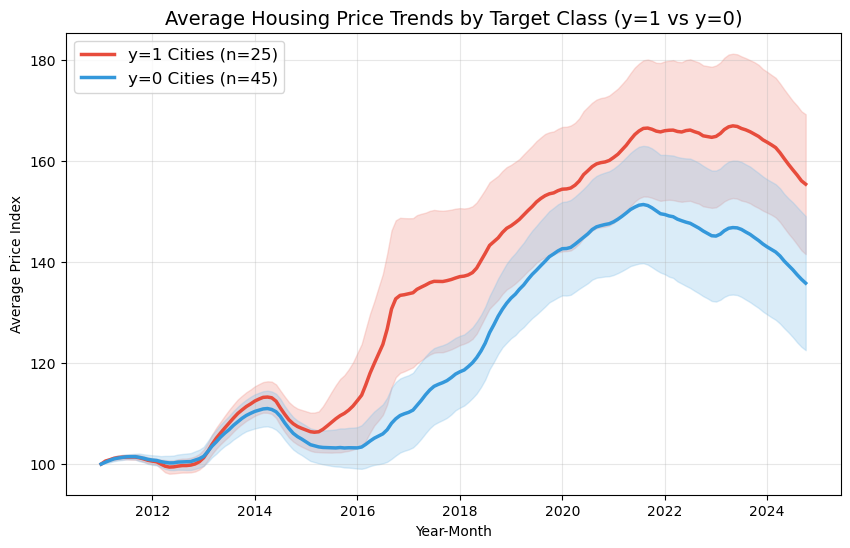

In [3]:
# extract time series columns
ts_columns = [col for col in df.columns if col >= '2011-01' and col <= '2024-10']

# transform the time series columns to datetime format
months = pd.to_datetime(ts_columns, format='%Y-%m')

# calculate mean for each class (y = 1, y = 0)
y1_mean = df[df['y'] == 1][ts_columns].mean(axis=0).values
y0_mean = df[df['y'] == 0][ts_columns].mean(axis=0).values

# calculate standard deviation for each class
y1_std = df[df['y'] == 1][ts_columns].std(axis=0).values
y0_std = df[df['y'] == 0][ts_columns].std(axis=0).values

# plot the average trend for each class
plt.figure(figsize=(10, 6))
plt.plot(months, y1_mean, label=f'y=1 Cities (n={len(df[df["y"]==1])})', color='#E74C3C', linewidth=2.5)
plt.plot(months, y0_mean, label=f'y=0 Cities (n={len(df[df["y"]==0])})', color='#3498DB', linewidth=2.5)

# plot 0.5*sd for each class
plt.fill_between(months, y1_mean - 0.5*y1_std, y1_mean + 0.5*y1_std, color='#F1948A', alpha=0.3)
plt.fill_between(months, y0_mean - 0.5*y0_std, y0_mean + 0.5*y0_std, color='#85C1E9', alpha=0.3)

# set plot aesthetics
plt.title('Average Housing Price Trends by Target Class (y=1 vs y=0)', fontsize=14)
plt.xlabel('Year-Month', fontsize=10)
plt.ylabel('Average Price Index', fontsize=10)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

### 1.2 - imagine time series

Next, we need to transform our time series data into images. 

But before that we define a function `split_housing_price_data` in the following steps:
1. extract time series data $X$ in `df` to a NumPy array
2. extract label $y$ in `df` to a NumPy array
3. extract city names in `df` to a NumPy array
4. split into training and testing samples

In [4]:
def split_housing_price_data(df):
    '''
    split data to train and test array
    param:
        df: dataframe with columns ['city', 'y', '2011-01', ..., '2024-10'];
    return:
        train_ts: ndarray with shape [N, T], time series data for training;
        test_ts: ndarray with shape [N, T], time series data for testing;
        train_y: ndarray with shape [N,], label for training;
        test_y: ndarray with shape [N,], label for testing;
    '''
    # extract time series data to a NumPy array: shape = [N, T]
    ts_columns = [col for col in df.columns if '2011-01' <= col <= '2024-10']
    X = df[ts_columns].values
    
    # extract label to a NumPy array: shape = [N,]
    y = df['y'].values
    
    # extract prediction periods prices to a Numpy array
    pred_columns = [col for col in df.columns if '2024-11' <= col <= '2025-04']
    true_price = df[pred_columns].values

    # extract city names to a NumPy array: shape = [N,]
    city = df['city'].values
    
    # split data into training and testing sets
    train_ts, test_ts, train_y, test_y, train_city, test_city, _, true_test_price = train_test_split(X, y, city, true_price, test_size=0.2,random_state=42, shuffle=True, stratify=y)

    return train_ts, test_ts, train_y, test_y, train_city, test_city, true_test_price

# split the data into training and testing sets
train_ts, test_ts, train_y, test_y, train_city, _, true_test_price = split_housing_price_data(df)
# display the shapes of the resulting arrays
train_ts.shape, test_ts.shape, train_y.shape, test_y.shape

((56, 166), (14, 166), (56,), (14,))

Then, we transform our time series into images using 3 algorithms: Gramian Angular Fields, Markov Transition Field and Recurrence Plot. Each converts a 1-dimensional time series into a gray-scale image. We then stack the three gray-scale images along the channel dimension to form a 3-channel image (similar in structure to an RGB image). This 3-channel representation is well-suited as input to a convolutional neural network

For the technical details of these 3 algorithms, you can refer to [Wang and Oates (2015)](https://www.ijcai.org/Proceedings/15/Papers/553.pdf). But here for simplicity, you can think of these algorithms as simply visulizing patterns (trends, cycles, anomalies) of time series.

To finish above task, we define a function `image_time_series` in the following steps:
1. create GAF images
2. create MTF images
3. create RP images
4. stack the images along the channel dimension

In [5]:
def image_time_series(ts):
    '''
    Convert time series data into images
    param:
        ts: ndarray with shape [N, T], time series;
    return:
        images: ndarray with shape [N, 3, T, T], 3 channels image of time series;
    '''
    # create GAF images 
    gaf = GramianAngularField()
    gaf_image = gaf.fit_transform(ts) # shape [N, T, T]

    # create MTF images
    mtf = MarkovTransitionField(strategy='uniform')
    mtf_image = mtf.fit_transform(ts) # shape [N, T, T]

    # create RP images
    rp = RecurrencePlot(threshold='point')
    rp_image = rp.fit_transform(ts) # shape [N, T, T]

    # stack the images along the channel dimension
    images = np.stack([gaf_image, mtf_image, rp_image], axis=1) #  shape [N, 3, T, T]
    
    return images

train_X = image_time_series(train_ts)
test_X = image_time_series(test_ts)
train_X.shape, test_X.shape

((56, 3, 166, 166), (14, 3, 166, 166))

In the following codes, we take Xiamen as an example to show what we have after transforming our time series into images.

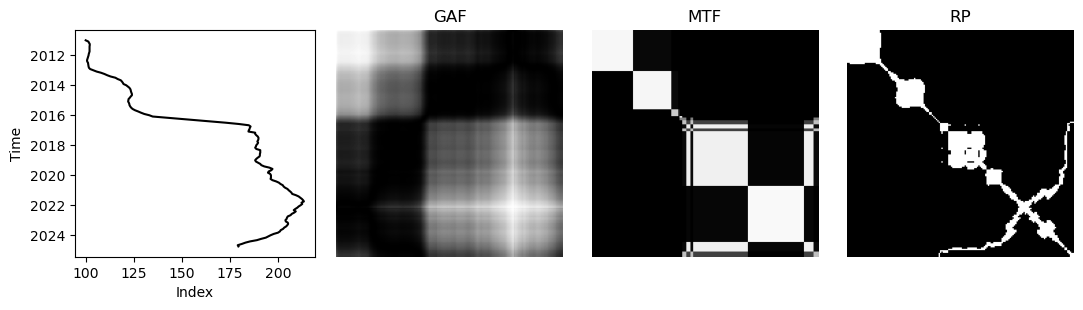

In [6]:
# find index of '厦门' 
idx = np.where(train_city == '厦门')[0][0]

# extract Xiamen's time series and images
ts = train_ts[idx]                   # shape: [T]
images = train_X[idx]               # shape: [3, T, T]

# create plot with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(11, 3))

# draw curve of time series
axes[0].plot(ts, months, color='black')
axes[0].invert_yaxis()
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Time')

# draw GAF image
axes[1].imshow(images[0], cmap='gray')
axes[1].set_title('GAF')
axes[1].axis('off')

# draw MTF image
axes[2].imshow(images[1], cmap='gray')
axes[2].set_title('MTF')
axes[2].axis('off')

# draw RP image
axes[3].imshow(images[2], cmap='gray')
axes[3].set_title('RP')
axes[3].axis('off')

plt.tight_layout()
plt.show()

### 1.3 - transform to DataLoader

Finally, we define a function `prepare_loader`, which transform our Numpy array data into DataLoader, in the following steps:
1. transform `X` and `y` into torch.tensor
2. bundle `X` and `y` into TensorDataset
3. transform TensorDataset into DataLoader

In [7]:
# to DataLoader
def prepare_loader(X, y, batch_size=64, shuffle=True):
    '''
    Prepare DataLoader for training and testing
    param:
        X: ndarray with shape [N, C, T, T], images;
        y: ndarray with shape [N,], labels;
        batch_size: int, size of each batch;
    return:
        loader: DataLoader object;
    '''
    # transform X into torch.tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # transform y into torch.tensor
    y_tensor = torch.tensor(y, dtype=torch.long)

    # bundle X_tensor and y_tensor into a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # transform the dataset into a DataLoader
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return loader

train_loader = prepare_loader(train_X, train_y, shuffle=False)
test_loader = prepare_loader(test_X, test_y, shuffle=False)

## 2 - ResNet

We would use ResNet18 to classify the time series. In the following sections, we show the architecture of ResNet18 first, and then introduce the implementation using `PyTorch`.

### 2.1 - architecture

ResNet18 consists of 18 layers including 17 convolution layer and a final fully connect layer. The following table shows the architecture of ResNet18.

| Layer    | Layer Details                    | Kernel Size          | Stride | Padding | Output Size       |
|----------|----------------------------------|----------------------|--------|---------|--------------------|
| Input    | -                                | -                    | -      | -       | 3 × 166 × 166      |
| Conv1    | convolution                      | 64, 7 × 7            | 2      | 3       | 64 × 83 × 83       |
| BN & ReLU|                                  |                      |        |         | 64 × 83 × 83       |
| MaxPool  | max pooling                      | 3 × 3                | 2      | 1       | 64 × 42 × 42       |
| Layer1   | 2 × BasicBlock                   | 64, 3 × 3            | [1, 1] | 1       | 64 × 42 × 42       |
| Layer2   | 2 × BasicBlock                   | 128, 3 × 3           | [2, 1] | 1       | 128 × 21 × 21      |
| Layer3   | 2 × BasicBlock                   | 256, 3 × 3           | [2, 1] | 1       | 256 × 11 × 11      |
| Layer4   | 2 × BasicBlock                   | 512, 3 × 3           | [2, 1] | 1       | 512 × 6 × 6        |
| AvgPool  | AdaptiveAvgPool2d                | -                    | -      | -       | 512 × 1 × 1        |
| FC       | Linear(512 → num_classes)        | -                    | -      | -       | num_classes        |

At the heart of ResNet18 is the BasicBlock, which implements the concept of residual learning. It has 2 paths：
- **The main path** consists of two convolutional layers, each followed by batch normalization. The first convolution typically uses a stride of 1 (or 2 for downsampling), and both use a kernel size of 3×3. A ReLU activation is applied after the first convolution.
- **The shortcut path** directly passes the input forward. If the input and output dimensions match, the shortcut is a simple identity mapping. If they differ (such as during downsampling or when the number of output channels increases), a 1×1 convolution with stride is used to transform the input to match the main path's output shape.

The outputs from both paths are then element-wise added, and a final ReLU activation is applied.

<table>
  <tr>
    <td colspan="3" align="center">Input </td>
  </tr>
  <tr>
    <td>Conv (3×3, stride=S)</td>
    <td rowspan="4"></td>
    <td rowspan="4">Identity or Conv (1×1, stride=S)</td>
  </tr>
  <tr>
    <td>BatchNorm + ReLU</td>
  </tr>
  <tr>
    <td>Conv (3×3, stride=1)</td>
  </tr>
  <tr>
    <td>BatchNorm</td>
  </tr>
  <tr>
    <td colspan="3" align="center">Add</td>
  </tr>
  <tr>
    <td colspan="3" align="center">ReLU</td>
  </tr>
  <tr>
    <td colspan="3" align="center">Output</td>
  </tr>
</table>




### 2.2 - BasicBlock

Below is the `PyTorch` implementation of the `BasicBlock` module used in ResNet18:
- `__init__` method initializes all layers used in the residual block, it contains
  - `conv1`: 3x3 conv with specified stride (downsamples if stride > 1)
  - `conv2`: 3x3 conv with fixed stride=1
  - `bn1`, `bn2`: Applied after each convolution for stable training.
  - `shortcut`: initialized as identity (nn.Sequential()). Replaced with 1x1 conv + BN only if stride != 1 (spatial dimension mismatch), or in_channels != out_channels (channel count mismatch).

- `forward` method do forward propagation, its computation steps:
  1. Main Path: x → `conv1` → `bn1` → `ReLU` → `conv2` → `bn2` → output_main
  2. Shortcut Path: x → `shortcut` (identity or 1x1 conv) → output_shortcut
  3. Residual Addition: output = output_main + output_shortcut
  4. Final Activation: `ReLU`(output)


In [8]:
class BasicBlock(nn.Module):
    expansion = 1 # expansion factor for adjust output channels

    def __init__(self, in_channels, out_channels, stride=1):
        """
        initialize BasicBlock module

        params:
            in_channels: int, channels of input,
            out_channels: int, channels of output,
            stride: int, stride for first convolution
        """
        super(BasicBlock, self).__init__()

        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # first batch normalization layer
        self.bn1 = nn.BatchNorm2d(out_channels)

        # second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # second batch normalization layer
        self.bn2 = nn.BatchNorm2d(out_channels)

        # shortcut path
        self.shortcut = nn.Sequential()  # default is identity

        # if stride != 1 or input output channels differ
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                # apply 1x1 convolution to match dimensions
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                # apply batch normalization
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Conv1 + BN1 + ReLU
        out = F.relu(self.bn1(self.conv1(x)))

        # Conv2 + BN2
        out = self.bn2(self.conv2(out))

        # add main path and shortcut path
        out += self.shortcut(x)

        # apply ReLU activation
        out = F.relu(out)

        return out

### 2.3 - build resnet18

Below is the implementation of ResNet architecture with configurable residual blocks (decided by `block` and `num_blocks`):
- `__init__` method: initializes the ResNet architecture with four residual layers, it contains:
  - initial processing layers: `Conv1`, `bn1`, `ReLU`, `MaxPool`
  - residual Layers: 
    - layer1: `num_blocks[0]` blocks, 64 channels
    - layer2: `num_blocks[1]` blocks, 128 channels (downsampled)
    - layer3: `num_blocks[2]` blocks, 256 channels (downsampled)
    - layer4: `num_blocks[3]` blocks, 512 channels (downsampled)
  - final classifier layers: `AvgPool`, Flatten, `Linear`
- `_make_layer` method: 
  - step 1 Stride Configuration: The first block uses the specified `stride`, all subsequent blocks in the same layer use `stride=1`
  - step 2 Block Construction：For each stride in strides, instantiate a new block
  - step 3 Channel Management: After each block, update self.in_channels to prepare for the next block
- `forward` method:
  - step 1 initial down-sampling: `conv1` → `bn1` → `ReLU` → `maxpool` →
  - step 2 pass through residual layers: `layer1` → `layer2` → `layer3` → `layer4` →
  - step 3 final produces class logits: `avgpool` → flatten → `linear`


In [9]:
class ResNet(nn.Module):
    """
    Implementation of ResNet architecture with configurable residual blocks.
    Supports both BasicBlock (for ResNet-18/34) and Bottleneck (for deeper variants).
    """

    def __init__(self, block, num_blocks, num_classes=2):
        """
        Initializes the ResNet architecture with 4 residual layers

        params:
            block: nn.Module, type of residual block (e.g., BasicBlock)
            num_blocks: list, number of residual blocks in each layer (e.g., [2, 2, 2, 2] for ResNet-18)
            num_classes: int, number of classes for classification task
        """
        super(ResNet, self).__init__()

        # input channels for basic block
        self.in_channels = 64

        # initial convolution, BN, ReLU and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # build 4 layers of BasicBlock
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # final average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 全局平均池化层
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Constructs a sequential container of residual blocks

        params:
            block: nn.Module, type of residual block (e.g., BasicBlock)
            out_channels: int, number of output channels for the blocks
            num_blocks: int, number of blocks in this layer
            stride: int, stride for the first block in this layer

        return:
            nn.Sequential: nn.Module, stacked residual blocks
        """
        # define the stride for each block
        strides = [stride] + [1] * (num_blocks - 1) # The first block uses the specified stride, subsequent blocks use stride=1
        # define a list to hold the blocks
        layers = []

        # build each block
        for stride in strides:
            # append a block to the layers list
            layers.append(block(self.in_channels, out_channels, stride))
            # updata the input channels
            self.in_channels = out_channels * block.expansion

        # stacked residual blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Defines the forward propagation pipeline

        params:
            x: input image tensor with shape (N, C, H, W)

        return:
            out: output tensor with shape (N, num_classes)
        """
        # initial convolution, batch normalization, ReLU and max pooling
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        # pass through 4 layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # final average pooling
        out = self.avgpool(out)

        # flatten the output to a vector
        out = torch.flatten(out, 1)

        # apply the fully connected layer
        out = self.linear(out)

        return out
    
def ResNet18():
    """Builds ResNet-18 with BasicBlocks and standard layer configuration"""
    return ResNet(BasicBlock, [2, 2, 2, 2])

## 3 - Train and Test Utility

Our `train` function and `test` are almost the same as in the previous chapters. The only difference is that we could use GPU to accelerate computation. So we add a new parameter `device` and use `.to(device)` to move model, data and target to GPU.

In [10]:
# train function
def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        loss_list.append([])
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
                loss_list[-1].append(loss.item())
    return loss_list

# test function
def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    test_loss = 0
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            probs = torch.softmax(output, dim=1)[:, 1]  # 概率取 class 1
            
            all_probs.append(probs.cpu())
            all_targets.append(target.cpu())

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    probs = torch.cat(all_probs, dim=0).numpy()
    targets = torch.cat(all_targets, dim=0).numpy()

    return probs, targets


In the following codes, we instantiate our model, loss function, optimizer. And here we use learning rate scheduler, which dynamically adjusts the learning rate according to the cosine function curve.

In [11]:
# set device 
device = torch.device(
    # for NVIDIA GPU
    'cuda' if torch.cuda.is_available() else 
    # for macOS with MPS support
    'mps' if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available() else
    # otherwise use CPU
    'cpu'
)
# instantiate model, criterion, optimizer and scheduler
model = ResNet18()
# use CrossEntropyLoss since our output is logits
criterion = nn.CrossEntropyLoss()
# use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)
# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# train the model
loss_list = train(model, train_loader, criterion, optimizer, 100, device=device)

Epoch 0, Batch 0, Loss: 0.6770320534706116
Epoch 1, Batch 0, Loss: 0.23333637416362762
Epoch 2, Batch 0, Loss: 0.012087374925613403
Epoch 3, Batch 0, Loss: 0.0014784598024562001
Epoch 4, Batch 0, Loss: 0.0008532408392056823
Epoch 5, Batch 0, Loss: 0.0006789316539652646
Epoch 6, Batch 0, Loss: 0.0005266704829409719
Epoch 7, Batch 0, Loss: 0.00042517410474829376
Epoch 8, Batch 0, Loss: 0.00036528933560475707
Epoch 9, Batch 0, Loss: 0.00031286836019717157
Epoch 10, Batch 0, Loss: 0.00026449523284099996
Epoch 11, Batch 0, Loss: 0.0002250655961688608
Epoch 12, Batch 0, Loss: 0.00019568130664993078
Epoch 13, Batch 0, Loss: 0.00017696335271466523
Epoch 14, Batch 0, Loss: 0.00016506008978467435
Epoch 15, Batch 0, Loss: 0.00015331442409660667
Epoch 16, Batch 0, Loss: 0.0001402470370521769
Epoch 17, Batch 0, Loss: 0.0001258509437320754
Epoch 18, Batch 0, Loss: 0.00011072720371885225
Epoch 19, Batch 0, Loss: 9.65669023571536e-05
Epoch 20, Batch 0, Loss: 8.488512685289606e-05
Epoch 21, Batch 0, Lo

In [12]:
# predict on the test data
probs_resnet, targets = test(model, test_loader, criterion, device=device)

Test Loss: 0.0302


## 4 - Results and Comparison

In the following section, we would compare the results of time series imaging & ResNet18 method with traditional econometric methods (ARIMA(1, 1, 1)).

### 4.1 - ARIMA 

Firstly, we fit an ARIMA(1, 1, 1) model. This model is primarily designed for time series prediction instead of classification. So here we assume the error term follows a standard normal distribution then we could have the distribution of $\widehat{\text{Price}}_{T+6}$, the probability for $P(Y = 1)$ is defined as the $P(\widehat{\text{Price}}_{T+6} \geq \text{Price}_{T})$

In [13]:
def fit_ARIMA(ts, arima_order=(1, 1, 1)):
    """
    Fit ARIMA model to time series data
    param:
        ts: ndarray with shape [N, T], time series data;
        arima_order: tuple, order of the ARIMA model (p, d, q);
    return:
        y_pred: ndarray with shape [N, 6], predicted values for the next 6 months;
        score: float, P(Y = 1) defined above;
    """
    # store the number of time series
    N = ts.shape[0]
    # initialize arrays to store predictions
    y_pred = np.zeros((N, 6))
    # initialize arrays to store standard errors
    y_std = np.zeros((N, 6))
    
    # loop through each time series
    for i in range(N):
        series = ts[i]
        # fit ARIMA model
        model = ARIMA(series, order=arima_order)
        fitted = model.fit()
        # get forecast for the next 6 months
        forecast_result = fitted.get_forecast(steps=6)
        # store predicted mean and standard error
        y_pred[i] = forecast_result.predicted_mean
        y_std[i] = forecast_result.se_mean
    # calculate probability
    z_score = (ts[:, -1] - y_pred[:, -1]) / y_std[:, -1]
    score = norm.sf(z_score)

    return y_pred, score

_, probs_arima = fit_ARIMA(ts = test_ts)

### 4.2 - ROC comparison

We can compare our results of time series imaging & ResNet18 method with ARIMA(1, 1, 1) method. We observe that ResNet18 curve lies consistently above the ARIMA curve. And AUC of 0.933 indicates the ResNet18 model performs well at distinguishing between rising and non-rising housing prices cities.


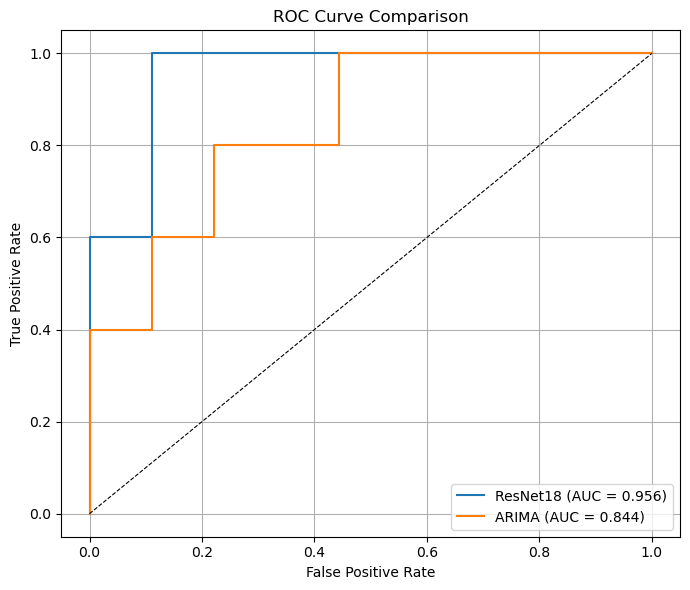

In [14]:
def plot_roc_curves(targets, probs_resnet, probs_arima):
    # 计算 ROC 曲线和 AUC
    fpr_resnet, tpr_resnet, _ = roc_curve(targets, probs_resnet)
    auc_resnet = auc(fpr_resnet, tpr_resnet)

    fpr_arima, tpr_arima, _ = roc_curve(targets, probs_arima)
    auc_arima = auc(fpr_arima, tpr_arima)

    # 绘图
    plt.figure(figsize=(7, 6))
    plt.plot(fpr_resnet, tpr_resnet, label=f'ResNet18 (AUC = {auc_resnet:.3f})')
    plt.plot(fpr_arima, tpr_arima, label=f'ARIMA (AUC = {auc_arima:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curves(targets, probs_resnet, probs_arima)
